<a href="https://colab.research.google.com/github/AliaksandrSiarohin/articulated-animation/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Demo for paper "Motion Representations for Articulated Animation"
**Clone repository. First install git lfs. Pulling all checkpoints may take a while**


**Load source image and driving video.**

In [11]:
import imageio
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings

# from re_demo import load_checkpoints

import sys
import yaml
from tqdm import tqdm

from skimage.transform import resize
from skimage import img_as_ubyte
import torch
from sync_batchnorm import DataParallelWithCallback
from modules.generator import Generator
from modules.region_predictor import RegionPredictor
from modules.avd_network import AVDNetwork
from animate import get_animation_region_params
import matplotlib
matplotlib.use('Agg')
import pickle as pkl

warnings.filterwarnings("ignore")
dataset = 'ted'
source_name = f"data/{dataset}/ted_proportionX.png" # "Hitmonchan"
source_image = imageio.imread(source_name)
driving_video = imageio.mimread(f'data/{dataset}/driving1.mp4')

video_shape = (384, 384) if dataset=='ted' else (256, 256)
source_image = resize(source_image, video_shape)[..., :3]
driving_video = [resize(frame, video_shape)[..., :3] for frame in driving_video]
assert source_image.shape==driving_video[0].shape, f"Frame and image shape mismatch: {source_image.shape}"


In [12]:

if sys.version_info[0] < 3:
    raise Exception("You must use Python 3 or higher. Recommended version is Python 3.7")


def load_checkpoints(config_path, checkpoint_path, cpu=False):
    with open(config_path) as f:
        config = yaml.safe_load(f)

    generator = Generator(num_regions=config['model_params']['num_regions'],
                          num_channels=config['model_params']['num_channels'],
                          **config['model_params']['generator_params'])
    if not cpu:
        generator.cuda()

    region_predictor = RegionPredictor(num_regions=config['model_params']['num_regions'],
                                       num_channels=config['model_params']['num_channels'],
                                       estimate_affine=config['model_params']['estimate_affine'],
                                       **config['model_params']['region_predictor_params'])
    if not cpu:
        region_predictor.cuda()

    avd_network = AVDNetwork(num_regions=config['model_params']['num_regions'],
                             **config['model_params']['avd_network_params'])
    if not cpu:
        avd_network.cuda()

    if cpu:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(checkpoint_path)

    generator.load_state_dict(checkpoint['generator'])
    region_predictor.load_state_dict(checkpoint['region_predictor'])
    if 'avd_network' in checkpoint:
        avd_network.load_state_dict(checkpoint['avd_network'])

    if not cpu:
        generator = DataParallelWithCallback(generator)
        region_predictor = DataParallelWithCallback(region_predictor)
        avd_network = DataParallelWithCallback(avd_network)

    generator.eval()
    region_predictor.eval()
    avd_network.eval()

    return generator, region_predictor, avd_network
generator, region_predictor, avd_network = load_checkpoints(config_path=f'config/{dataset}{video_shape[0]}.yaml',
                                                            checkpoint_path=f'checkpoints/{dataset}{video_shape[0]}.pth')

**Perform animation.**

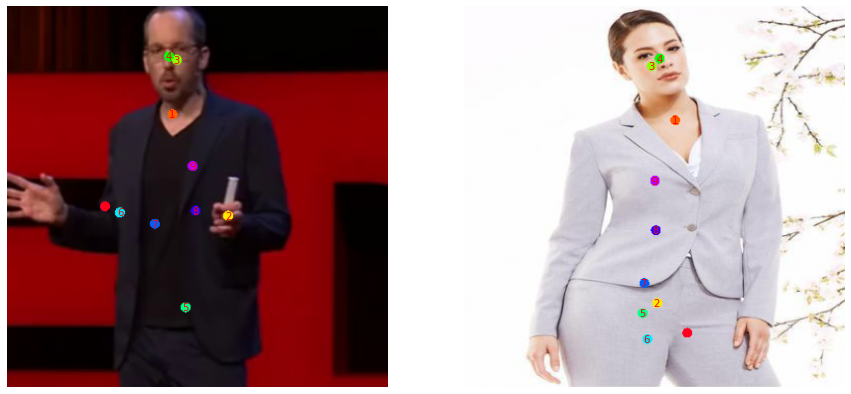

In [13]:
%matplotlib inline
from skimage import img_as_ubyte


def make_animation(source_image, driving_video, generator, region_predictor, avd_network,
                   animation_mode='standard', cpu=False):
    with torch.no_grad():
        predictions = []
        source = torch.tensor(source_image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)
        if not cpu:
            source = source.cuda()
        driving = torch.tensor(np.array(driving_video)[np.newaxis].astype(np.float32)).permute(0, 4, 1, 2, 3)
        source_region_params = region_predictor(source)
        driving_region_params = region_predictor(driving[:, :, 0]) # First frame

    return source_region_params, driving_region_params


from skimage.draw import disk

kp_size = 5
draw_border = True
colormap = plt.get_cmap('gist_rainbow')
region_bg_color = [1, 1, 1]

def draw_image_with_kp(image, ax, kp_array):
    
    image = np.copy(image)
    spatial_size = np.array(image.shape[:2][::-1])[np.newaxis]
    kp_array = spatial_size * (kp_array + 1) / 2
    num_regions = kp_array.shape[0]
    for kp_ind, kp in enumerate(kp_array):
        rr, cc = disk((kp[1], kp[0]), kp_size, shape=image.shape[:2])
        ax.text(kp[0], kp[1], f"{kp_ind}", dict(color='red', va='center', ha='center'))
        image[rr, cc] = np.array(colormap(kp_ind / num_regions))[:3]
    ax.imshow(image)
    ax.axis('off')
    return image

source_region_params, driving_region_params = make_animation(source_image, driving_video, generator, 
                             region_predictor, avd_network, animation_mode='avd')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

draw_image_with_kp(driving_video[0], axs[0], driving_region_params['shift'][0].data.cpu().numpy())
draw_image_with_kp(source_image, axs[1], source_region_params['shift'][0].data.cpu().numpy())

plt.show()

In [4]:
#! user-defined keypoints
# with open('keypoints_pokemon.pkl', 'rb') as f:
#     keypoints = pkl.load(f)

# try:
#     keypoints = keypoints[f'{source_name.lower()}']
#     draw_image_with_kp(source_image, keypoints)
# except:
#     print(f'no user defined keypoints for {source_name}')



## Optical Flow Visualization

In [136]:
import cv2
import numpy as np
import torch.nn.functional as F
def optical_flow_ang(flow, occlusion, shape=(256, 256, 3)):
    hsv = np.zeros(shape, dtype=np.uint8)
    hsv[..., 1] = 255
    scale = shape[0]/flow.shape[1]
    if scale!=1:
        flow = flow.permute(0, 3, 1, 2)
        flow = F.interpolate(flow, scale_factor=scale).squeeze(0).numpy()
        occlusion = F.interpolate(occlusion, scale_factor=scale).squeeze(0)
        occlusion = occlusion.permute(1, 2, 0).numpy()
        occlusion = np.concatenate((occlusion, np.zeros_like(occlusion), np.zeros_like(occlusion)), axis=-1)
    mag, ang = cv2.cartToPolar(flow[0, ...], flow[1, ...])
    hsv[..., 0] = ang * 180/ np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR), occlusion


In [134]:
from torchvision.utils import save_image
import torch.nn.functional as F
import numpy as np
import pickle

def make_animation(source_image256, source_image512, driving_video, generator, region_predictor, avd_network, dataset,
                   animation_mode='standard', ground_truth=None, cpu=False, keypoints=None):

    out = None
    
    with torch.no_grad():
        predictions = []
        optical_flow
        # Compute keypoints, affine transformation from 256 resolution
        source_image256 = source_image256
        source256 = torch.tensor(source_image256[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)
        if not cpu:
            source256 = source256.cuda()
        driving = torch.tensor(np.array(driving_video)[np.newaxis].astype(np.float32)).permute(0, 4, 1, 2, 3)

        # TODO: Add keypoints manually
        if keypoints is not None:
            pass
        else:
            keypoints = None

        source_region_params = region_predictor(source256, keypoints)
        driving_region_params_initial = region_predictor(driving[:, :, 0])

        source512 = torch.tensor(source_image512[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)
        if not cpu:
            source512 = source512.cuda()
        for frame_idx in tqdm(range(driving.shape[2])):
            driving_frame = driving[:, :, frame_idx]
            if not cpu:
                driving_frame = driving_frame.cuda()
            driving_region_params = region_predictor(driving_frame)
            
            new_region_params = get_animation_region_params(source_region_params, driving_region_params,
                                                            driving_region_params_initial, avd_network=avd_network,
                                                            mode=animation_mode)
            
            
            out = generator(source256, source512, source_region_params=source_region_params, driving_region_params=new_region_params)
            res = out['prediction'].shape[-1]
            of, om = optical_flow_ang(out['optical_flow'].detach().cpu(), out['occlusion_map'].detach().cpu(), (res, res, 3))
            deformed = np.transpose(out['deformed'].data.cpu().numpy(), [0, 2, 3, 1])[0]
            pred = np.transpose(out['prediction'].data.cpu().numpy(), [0, 2, 3, 1])[0]
            predictions.append(np.concatenate([deformed, pred, om], axis=1))
            optical_flow.append(of)
        return predictions



In [135]:
#save resulting video=
predictions = make_animation(source_image, source_image, 
        driving_video, generator, region_predictor, avd_network, dataset, animation_mode='avd')

# HTML(display(source_image, driving_video, predictions).to_html5_video())

  0%|          | 0/160 [00:00<?, ?it/s]

tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(0.8701, device='cuda:0')
tensor(0.0716, device='cuda:0') tensor(0.9991, device='cuda:0') tensor(0.8396, device='cuda:0')
tensor(0.) tensor(1.) tensor(3.6169e-05)
tensor(0.) tensor(0.7689) tensor(0.1324)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 3 and the array at index 2 has size 384

In [63]:
# image = (255 * img).astype(np.uint8)

imageio.mimsave('ted_proportionX.mp4', [(frame*255).astype(np.uint8) for frame in predictions])

In [31]:
vid256 = imageio.mimread('obama_ted_256.mp4')
vid512 = imageio.mimread('obama_ted_512.mp4')

frames = []
for f1, f2 in zip(vid256, vid512):
    f1 = F.interpolate(torch.Tensor(f1).permute(2, 0, 1).unsqueeze(0), size=(512, 512))
    
    f2 = torch.tensor(f2).permute(2, 0, 1)
    frame = np.concatenate([f1.squeeze().cpu().numpy(), f2.cpu().numpy()], axis=2)
    frames.append(frame)
imageio.mimsave('obama_ted.mp4', frames)

ValueError: Image must be 2D (grayscale, RGB, or RGBA).

In [ ]:
sample_by = 2


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))


names = ['256', '512']
for idx, output in enumerate([out256, out512]):
    optical_flow = output['optical_flow'][0]
    U, V = optical_flow.permute(2, 0, 1).detach().cpu().numpy()
    
    grid_size = video_shape[0]//4
    if names[idx]=='512':
        grid_size *= 2
        sample_by *= 2
    grid_size /= sample_by  
    X, Y = np.meshgrid(np.arange(-1., 1., 2/grid_size), np.arange(-1., 1.,  2/grid_size))
    U, V = U[::sample_by, ::sample_by], V[::sample_by, ::sample_by]

    ax[idx].quiver(X, Y, U, V)
    ax[idx].xaxis.set_ticks([])
    ax[idx].yaxis.set_ticks([])
    ax[idx].set_aspect('equal')
    ax[idx].set_title(f'Optical Flow {names[idx]}')
plt.show()


## Interpolate Optical Flow

In [ ]:
import torch.nn.functional as F

opt_flow_interp = {}
of = out256['optical_flow'][0].permute(2, 0, 1)

for mode in ['nearest', 'bicubic', 'bilinear', 'area', 'nearest-exact']:
    of_ = F.interpolate(of[None], size=(128, 128), mode=mode)
    opt_flow_interp[mode] = of_.squeeze(0)
        

grid_size = 512/4
sample_by = 4
fig, ax = plt.subplots(nrows=1, ncols=len(opt_flow_interp.keys()), figsize=(12, 12))
grid_size /= sample_by  
X, Y = np.meshgrid(np.arange(-1., 1., 2/grid_size), np.arange(-1., 1.,  2/grid_size))

idx = 0
for key, value in opt_flow_interp.items():
    optical_flow = value
    U, V = optical_flow.detach().cpu().numpy()
    
    U, V = U[::sample_by, ::sample_by], V[::sample_by, ::sample_by]

    ax[idx].quiver(X, Y, U, V)
    ax[idx].xaxis.set_ticks([])
    ax[idx].yaxis.set_ticks([])
    ax[idx].set_aspect('equal')
    ax[idx].set_title(f'Optical Flow {key}')
    idx += 1

In [ ]:
tmp=torch.rand((1,3,4))
tmp.dim()

## Interpolate Occlusion map

## Sparse Motion Visualization

In [ ]:
grid_size = video_shape[0]//4

fig, ax = plt.subplots(nrows=4, ncols=3, figsize =(12, 12))
sparse_motions = out['sparse_motion'][0]
r_idx = 0
for idx, sp_m in enumerate(sparse_motions):

    U, V = sp_m.permute(2, 0, 1).detach().cpu().numpy()

    X, Y = np.meshgrid(np.arange(-1., 1., 2/grid_size), np.arange(-1., 1.,  2/grid_size))
    # Creating plot
    if idx!=0 and idx%3==0:
        r_idx += 1
    
    ax[r_idx, idx%3].quiver(X, Y, U, V)
    ax[r_idx, idx%3].xaxis.set_ticks([])
    ax[r_idx, idx%3].yaxis.set_ticks([])
    ax[r_idx, idx%3].set_aspect('equal')

sample_by = 2
grid_size /= sample_by
optical_flow = out['optical_flow'][0]

U, V = optical_flow.permute(2, 0, 1).detach().cpu().numpy()
X, Y = np.meshgrid(np.arange(-1., 1., 2/grid_size), np.arange(-1., 1.,  2/grid_size))
U, V = U[::sample_by, ::sample_by], V[::sample_by, ::sample_by]
ax[3, 2].quiver(X, Y, U, V)
ax[3, 2].xaxis.set_ticks([])
ax[3, 2].yaxis.set_ticks([])
ax[3, 2].set_aspect('equal')
ax[3, 2].set_title('Optical Flow')

# show plot

plt.savefig(f'of_{source_name.split(".")[0]}.png', dpi=800)
plt.show()

In [ ]:

optical_flow = out['optical_flow'][0]
U, V = optical_flow.permute(2, 0, 1).detach().cpu().numpy()
X, Y = np.meshgrid(np.arange(-1., 1., 2/grid_size), np.arange(-1., 1.,  2/grid_size))
U, V = U[::sample_by, ::sample_by], V[::sample_by, ::sample_by]

## Deformed Image

In [ ]:
print(out256['occlusion_map'].shape, out256['deformed'].shape[2:])

In [ ]:
import torch.nn.functional as F
keys = ['deformed', 'prediction', 'occlusion_map', 'input_skip', 'input_previous', 'input_occluded']

out['occlusion_map'] = F.interpolate(out['occlusion_map'], size=out['deformed'].shape[2:], mode='bilinear')
fig, ax = plt.subplots(nrows=1, ncols=len(keys), figsize=(10*len(keys), 10))
for idx, element in enumerate(keys):
    n_channel = out[element].shape[1]
    if n_channel in [1, 3]:
        img = out[element].permute(0,2,3,1)
    else:
        img = out[element]
    
    img = img.squeeze(0).detach().cpu()
    if n_channel==3:
        ax[idx].imshow(img)
    elif n_channel==1:
        ax[idx].imshow(img, cmap='gray')

    ax[idx].set_title(element)
    ax[idx].axis('off')
plt.savefig(f'res_{source_name.split(".")[0]}.png', dpi=800)
plt.show()

## User-defined keypoints / Saved

In [ ]:
keypoints = {
    'hitmonchan': [ # 256
        [76.0, 126.0],
        [149.0, 133.0],
        [219.0, 151.0],
        [166.0, 102.0],
        [160.0, 89.0],
        [141.0, 226.0],
        [118.0, 168.0],
        [140.0, 185.0],
        [157.0, 166.0],
        [143.0, 137.0],
    ],
    'gallade':[ # 256
        [92.0, 128.0],
        [124.0, 145.0],
        [212.0, 191.0],
        [129.0, 138.0],
        [112.0, 122.0],
        [126.0, 240.0],
        [121.0, 195.0],
        [127.0, 215.0],
        [136.0, 190.0],
        [130.0, 166.0],
    ]             
}

for k, v in keypoints.items():
    kp = torch.Tensor(v)
    tmp = []
    for idx, kp in enumerate(kp):
        tmp.append(2 * (kp/256 - 0.5))
    tmp = torch.stack(tmp).numpy()
    keypoints[k] = tmp
    
from pprint import pprint
pprint(keypoints)
import pickle as pkl
with open('keypoints_pokemon.pkl', 'wb') as f:
    pkl.dump(keypoints, f)

In [ ]:
vid_mraa = imageio.get_reader('mraa.mp4', 'ffmpeg')

for num in enumerate(vid_mraa):
    image = vid_mraa.get_data(num)
    fig = pylab.figure()

# EDGE Detection

%matplotlib inline
from canny_edge_detector import canny_edge_detector as ced
from PIL import Image, ImageFilter

  
# Detecting Edges on the Image using the argument ImageFilter.FIND_EDGES
image = image.filter(ImageFilter.FIND_EDGES)
img_np = np.array(image)
# Saving the Image Under the name Edge_Sample.png
image.save(r"Edge_Sample.png")
image = Image.open(source_name)
image = image.convert("L")
image_np = np.array(image)
print(image_np.shape)
detector = ced.cannyEdgeDetector([image_np], sigma=1.4, kernel_size=5, lowthreshold=0.1, highthreshold=0.1, weak_pixel=10)
imgs_final = detector.detect()